In [1]:
from data import series_data
from importlib import import_module
from torch.utils.data import DataLoader, random_split
from util import train, plot_confusion_matrix, plot_loss_accuracy

/Users/bsms9gep/Code/SaltAndPepper/venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'cinc2017'
model_name = 'SimpleLSTMNetwork'
units = 100
layers = 1
batch = 150
epochs = 20

In [3]:
dataset = import_module('datasets.' + dataset_name)
model = getattr(import_module('model'), model_name)
ts, labels = dataset.load_data()
data = series_data.Series(ts, labels)
train_size = int(0.8 * len(data))
valid_size = len(data) - train_size
train_data, valid_data = random_split(data, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
validation_loader = DataLoader(valid_data, batch_size=batch, shuffle=False)
net = model(num_classes=labels.max()+1, input_len=ts.size(2), 
                            hidden_units=units, hidden_layers=layers).to('cpu')
print(f'The number of samples for training is {train_size}.')
print(f'The number of parameters is {sum(p.numel() for p in net.parameters())}.')

Dataset already assembled in /Users/bsms9gep/Code/SaltAndPepper/datasets/cinc2017.
The number of samples for training is 4630.
The number of parameters is 7282002.


In [4]:
label_names = dataset.get_label_names()

Dataset already assembled in /Users/bsms9gep/Code/SaltAndPepper/datasets/cinc2017.


In [5]:
train_loss, train_acc, validation_loss, validation_acc, predictions, targets = train(net, 'cpu', train_loader, validation_loader, epochs)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:25<00:00,  4.28s/epoch, loss=0.255]


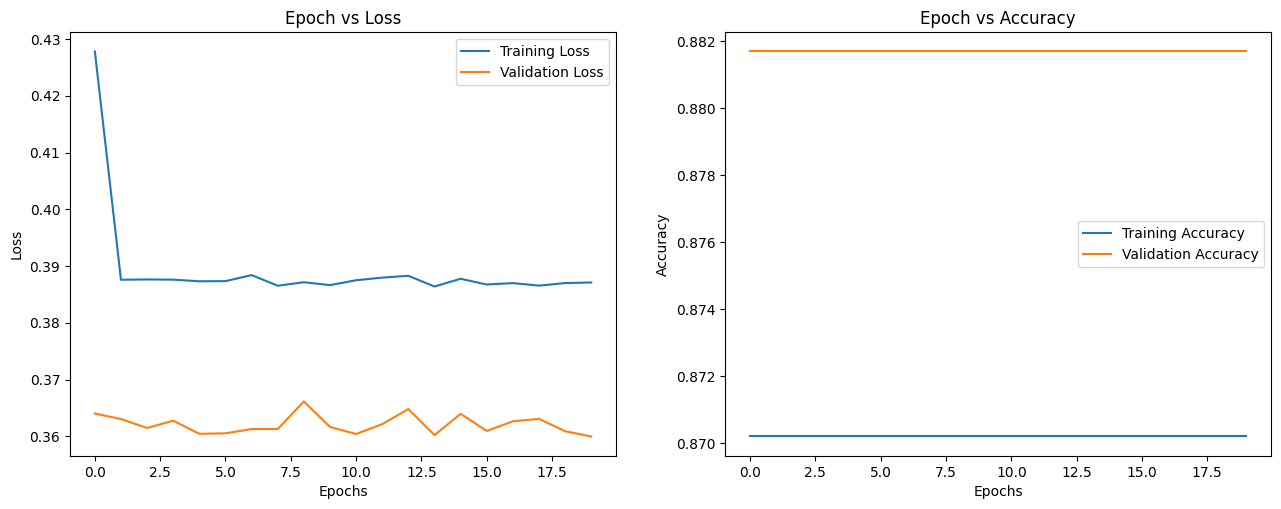

In [6]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

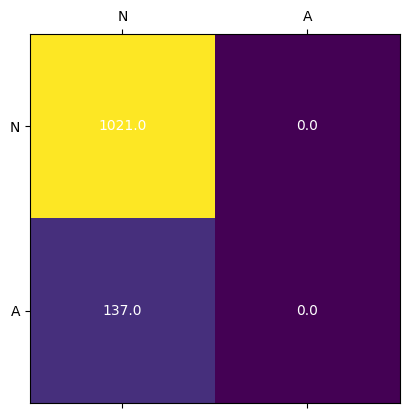

In [7]:
plot_confusion_matrix(targets, predictions, label_names)